# Tacotron2 Attention
<img src="./taco2.png" width="40%">

At this seminar you will implement the core part of Tacotron2 model.

You will be provided with an already trained model, encoder inference (as an example) and waveglow vocoder (code and model) to listen the results of your work

In [1]:
## Requirements

In [2]:
# already presented at DS
!pip install torch matplotlib numpy scipy librosa
# need to install
!pip install inflect unidecode pillow

In [3]:
## Loading stuff

Everything lies in github of the course
Except for WG model -- it's too big for GIT
So here it is, on Ya.Disk:
https://disk.yandex.ru/d/3TtZEmQBnj1SNA

WG vocoder has quite a poor perf at CPU, so you're strongly recommended to use GPU from DS (or from somewhere else)
you can use CPU though if you have several hours to generate the target samples

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [4]:
import sys

sys.path.insert(1, "waveglow")

import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from textproc import text_to_sequence

from tt2.model import Encoder, Postnet

/Users/oorgien/codes/DL-Audio-Course/seminars/seminar5/textproc.py:315: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/Users/oorgien/codes/DL-Audio-Course/seminars/seminar5/textproc.py:315: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# assert str(device) == 'cuda'

cpu


In [6]:
from matplotlib import pyplot as plt
from IPython.display import display, Audio
%matplotlib inline

In [7]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower',
                       interpolation='none')

# ~~Avengers~~Tacotron2 Assemble

## Load Pretrained TT2 Modules

In [8]:
N_SYMBOLS = 148
SYMBOLS_EMBEDDING_DIM = 512
N_MEL_CHANNELS = 80
N_FRAMES_PER_STEP = 1
ENCODER_EMBEDDING_DIM = 512
ATTENTION_DIM = 128
PRENET_DIM = 256
ATTENTION_RNN_DIM = 1024
ATTENTION_LOCATION_N_FILTERS = 32
ATTENTION_LOCATION_KERNEL_SIZE = 31
DECODER_RNN_DIM = 1024
P_ATTENTION_DROPOUT = 0.1
P_DECODER_DROPOUT = 0.1
GATE_THRESHOLD = 0.5
MAX_DECODER_STEPS = 1000

### Symbols Embedding

In [9]:
symbol_embedding = nn.Embedding(N_SYMBOLS, SYMBOLS_EMBEDDING_DIM)
ckpt = torch.load("models/symbol_embedding.pth", map_location="cpu")
symbol_embedding.load_state_dict(ckpt["state_dict"])
symbol_embedding = symbol_embedding.eval().to(device)
del ckpt

### Encoder

In [10]:
ckpt = torch.load("models/encoder.pth", map_location="cpu")
encoder = Encoder(ckpt["hparams"])
encoder.load_state_dict(ckpt["state_dict"])
encoder = encoder.eval().to(device)
del ckpt

In [11]:
encoder

Encoder(
  (convolutions): ModuleList(
    (0): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
)

### Postnet

In [12]:
ckpt = torch.load("models/postnet.pth", map_location="cpu")
postnet = Postnet(ckpt["hparams"])
postnet.load_state_dict(ckpt["state_dict"])
postnet = postnet.eval().to(device)
del ckpt

In [13]:
postnet

Postnet(
  (convolutions): ModuleList(
    (0): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): ConvNorm(
        (conv): 

### Attention and etc.

In [14]:
ckpt = torch.load("models/attention_memory_fc.pth", map_location="cpu")
attention_memory = nn.Linear(ENCODER_EMBEDDING_DIM, ATTENTION_DIM, bias=False)
attention_memory.load_state_dict(ckpt["state_dict"])
attention_memory = attention_memory.to(device)
del ckpt

In [15]:
ckpt = torch.load("models/prenet_fc1.pth", map_location="cpu")
prenet_fc1 = nn.Linear(N_MEL_CHANNELS * N_FRAMES_PER_STEP, PRENET_DIM, bias=False)
prenet_fc1.load_state_dict(ckpt["state_dict"])
prenet_fc1 = prenet_fc1.to(device)
del ckpt

In [16]:
ckpt = torch.load("models/prenet_fc2.pth", map_location="cpu")
prenet_fc2 = nn.Linear(PRENET_DIM, PRENET_DIM, bias=False)
prenet_fc2.load_state_dict(ckpt["state_dict"])
prenet_fc2 = prenet_fc2.to(device)
del ckpt

In [17]:
# attention rnn
ckpt = torch.load("models/RNN_Att.pth", map_location="cpu")
attention_rnn = nn.LSTMCell(PRENET_DIM + ENCODER_EMBEDDING_DIM, ATTENTION_RNN_DIM)
attention_rnn.load_state_dict(ckpt["state_dict"])
attention_rnn = attention_rnn.to(device)
del ckpt

In [18]:
# attention query
ckpt = torch.load("models/attention_query_fc.pth", map_location="cpu")
attention_query = nn.Linear(ATTENTION_RNN_DIM, ATTENTION_DIM, bias=False)
attention_query.load_state_dict(ckpt["state_dict"])
attention_query = attention_query.to(device)
del ckpt

In [19]:
ckpt = torch.load("models/attention_location_fc.pth", map_location="cpu")
attention_location_fc = nn.Linear(ATTENTION_LOCATION_N_FILTERS, ATTENTION_DIM, bias=False)
attention_location_fc.load_state_dict(ckpt["state_dict"])
attention_location_fc = attention_location_fc.to(device)
del ckpt

In [20]:
ckpt = torch.load("models/attention_location_conv.pth", map_location="cpu")
padding = int((ATTENTION_LOCATION_KERNEL_SIZE - 1) / 2)
attention_location_conv = nn.Conv1d(
    2, ATTENTION_LOCATION_N_FILTERS,
    kernel_size=ATTENTION_LOCATION_KERNEL_SIZE,
    padding=padding,
    bias=False
)
attention_location_conv.load_state_dict(ckpt["state_dict"])
attention_location_conv = attention_location_conv.to(device)
del ckpt

In [21]:
ckpt = torch.load("models/attention_v_fc.pth", map_location="cpu")
attention_v = nn.Linear(ATTENTION_DIM, 1, bias=False)
attention_v.load_state_dict(ckpt["state_dict"])
attention_v = attention_v.to(device)
del ckpt

In [22]:
ckpt = torch.load("models/RNN_Dec.pth", map_location="cpu")
decoder_rnn = nn.LSTMCell(ATTENTION_RNN_DIM + ENCODER_EMBEDDING_DIM, DECODER_RNN_DIM)
decoder_rnn.load_state_dict(ckpt["state_dict"])
decoder_rnn = decoder_rnn.to(device)
del ckpt

In [23]:
ckpt = torch.load("models/decoder_output.pth", map_location="cpu")
decoder_output_projection = nn.Linear(
    DECODER_RNN_DIM + ENCODER_EMBEDDING_DIM,
    N_MEL_CHANNELS * N_FRAMES_PER_STEP)
decoder_output_projection.load_state_dict(ckpt["state_dict"])
decoder_output_projection = decoder_output_projection.to(device)
del ckpt

In [24]:
ckpt = torch.load("models/decoder_gate.pth", map_location="cpu")
decoder_stop_gate_projection = nn.Linear(
    DECODER_RNN_DIM + ENCODER_EMBEDDING_DIM, 1, bias=True,
)
decoder_stop_gate_projection.load_state_dict(ckpt["state_dict"])
decoder_stop_gate_projection = decoder_stop_gate_projection.to(device)
del ckpt

<img src="./taco_scheme.png" width="100%">

<img src="./lsa.png" width="90%">

according to the scheme:
* Ws = attention_query()
* Vh = attention_memory() (Vh = decoder_processed_memory)
* Uf = attention_location_fc
* b = None (inside models already)
* v = attention_v
* F conv = attention_location_conv  
* after h of attention rnn and decoder rnn you need to set dropout
  (p = P_ATTENTION_DROPOUT and P_DECODER_DROPOUT, training = False)
* decoder_rnn((attention_h, context), (decoder_h, decoder_c)) => decoder_h, decoder_c
* mel = decoder_output_projection([decoder_h, attention_context])
* gate = decoder_stop_gate_projection([decoder_h, attention_context])

In [25]:
# inference
# text = "Hello, world"
text = "The only way of discovering the limits of the possible is to venture a little way past them into the impossible."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]

with torch.no_grad():
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)
    ).to(device).long()

    # Prepare input embeddings
    embedded_inputs = symbol_embedding(sequence).transpose(1, 2)
    encoder_outputs = encoder.inference(embedded_inputs)

    B, N, *_ = encoder_outputs.size()

    # prepare decoder for inference
    # zero decoder states
    attention_hidden = Variable(encoder_outputs.data.new(B, ATTENTION_RNN_DIM).zero_())
    attention_cell = Variable(encoder_outputs.data.new(B, ATTENTION_RNN_DIM).zero_())

    decoder_hidden = Variable(encoder_outputs.data.new(B, DECODER_RNN_DIM).zero_())
    decoder_cell = Variable(encoder_outputs.data.new(B, DECODER_RNN_DIM).zero_())

    attention_weights = Variable(encoder_outputs.data.new(B, N).zero_())
    attention_weights_sum = Variable(encoder_outputs.data.new(B, N).zero_())
    attention_context = Variable(encoder_outputs.data.new(B, ENCODER_EMBEDDING_DIM).zero_())

    # initialize memory
    decoder_memory = encoder_outputs
    decoder_processed_memory = attention_memory(decoder_memory)

    # prepare all-zero input frame
    decoder_input = Variable(encoder_outputs.data.new(
        B, N_MEL_CHANNELS * N_FRAMES_PER_STEP
    ).zero_())

    # start inference
    mel_outputs, gate_outputs, alignments = [], [], []
    while True:
        # prenet
        x = prenet_fc1(decoder_input)  # [B, PRENET_DIM]
        x = torch.dropout(torch.relu(x), p=0.5, train=True)
        prenet_output = torch.dropout(torch.relu(prenet_fc2(x)), p=0.5, train=True) # [B, PRENET_DIM]
        # Model have been learned from half information(dropout(0.5)) of previous mel.
        # Full information(dropout(0.0)) of previous mel make the decoder hard to correct prediction. 
        # Since Full information is too much for prenet that consist of (fc, dropout(0.5))×2.
        # https://github.com/NVIDIA/tacotron2/issues/247
        

        # RNN attention
        # output shape: [B, PRENET_DIM + ENCODER_EMBEDDING_DIM]
        attention_rnn_input = torch.cat((prenet_output, attention_context), dim=-1)
        attention_hidden, attention_cell = attention_rnn(attention_rnn_input, (attention_hidden, attention_cell))
        attention_hidden = torch.dropout(attention_hidden, p=P_ATTENTION_DROPOUT, train=False)
        # [B, ATTENTION_RNN_DIM]
        
        # Energies
        attention_weights_cat = torch.cat([attention_weights, attention_weights_sum], dim=0) # [2, TEXT_LEN]
        # [2, TEXT_LEN] -> [TEXT_LEN, ATTENTION_LOCATION_KERNEL_SIZE]
        location_attention_weights = attention_location_conv(attention_weights_cat).transpose(0, 1)
        energy = attention_v(
            torch.tanh(
                attention_query(attention_hidden) + # [B, ATTENTION_RNN_DIM] -> [B, 1, ATTENTION_DIM]
                decoder_processed_memory + # [B, TEXT_LEN, ATTENTION_DIM]
                # [TEXT_LEN, ATTENTION_LOCATION_KERNEL_SIZE] -> [1, TEXT_LEN, ATTENTION_DIM]
                attention_location_fc(location_attention_weights)  
            )
        )
        # [B, TEXT_LEN, 1]

        energy = energy.squeeze(-1)

        attention_weights = F.softmax(energy, dim=1)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), decoder_memory) # [B, 1, ENCODER_EMBEDDING_DIM]
        attention_context = attention_context.squeeze(1)

        attention_weights_sum += attention_weights

        # decoder rnn
        # output dim:  # [B, TEXT_LEN, ENCODER_EMBEDDING_DIM + ATTENTION_RNN_DIM]
        decoder_rnn_input = torch.cat((attention_hidden, attention_context), dim=-1)
        decoder_hidden, decoder_cell = decoder_rnn(decoder_rnn_input, (decoder_hidden, decoder_cell))
        decoder_hidden = torch.dropout(decoder_hidden, p=P_DECODER_DROPOUT, train=False)
        #..........
        
        decoder_data = torch.cat((decoder_hidden, attention_context), dim=1)
        # output dim: [B, DECODER_RNN_DIM + ENCODER_EMBEDDING_DIM] -> [B, N_MEL_CHANNELS * N_FRAMES_PER_STEP]
        decoder_output = decoder_output_projection(decoder_data) 

        stop_gate_prediction = decoder_stop_gate_projection(decoder_data)

        mel_outputs += [decoder_output.squeeze(1)]
        gate_outputs += [stop_gate_prediction]
        alignments += [attention_weights]

        if torch.sigmoid(stop_gate_prediction.data) > GATE_THRESHOLD:
                break
        elif len(mel_outputs) == MAX_DECODER_STEPS:
            print("Warning! Reached max decoder steps")
            break

        decoder_input = decoder_output

    alignments = torch.stack(alignments).transpose(0, 1)
    gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
    gate_outputs = gate_outputs.contiguous()
    mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
    mel_outputs = mel_outputs.view(mel_outputs.size(0), -1, N_MEL_CHANNELS)
    mel_outputs = mel_outputs.transpose(1, 2)

    mel_outputs_postnet = postnet(mel_outputs)

    synthesized_mels = mel_outputs + mel_outputs_postnet

In [26]:
# assertions
np.abs(mel_outputs.float().data.cpu().numpy()[0][42,:].mean() + 5.6) < 0.2


True

Here are mels and alignments
Alignment should be close to diagonal

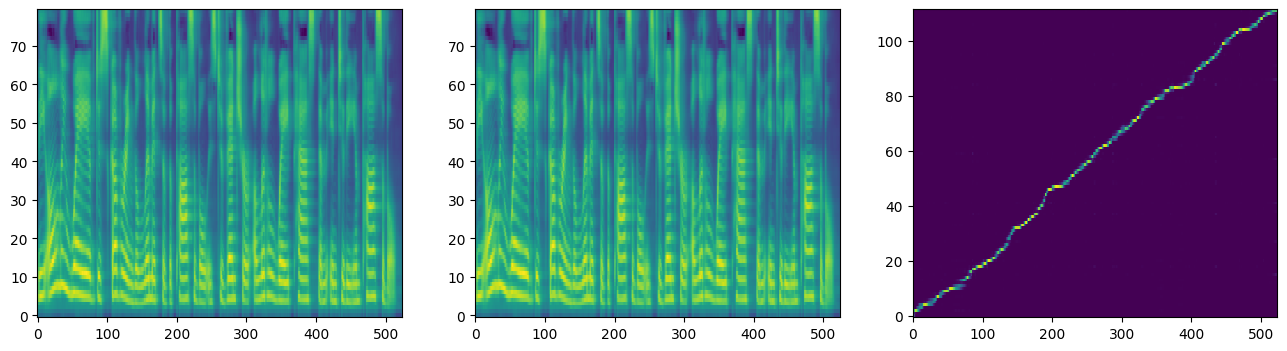

In [27]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           synthesized_mels.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [28]:
# load waveglow
# it complains about old code but that doesn't matter
waveglow_path = 'models/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path, map_location="cpu")['model']
waveglow = waveglow.to(device).eval()
# waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()

/Users/oorgien/codes/envs/tacotron/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'glow.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/oorgien/codes/envs/tacotron/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/oorgien/codes/envs/tacotron/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original 

In [29]:
# WG inference
with torch.no_grad():
    audio = waveglow.infer(synthesized_mels, sigma=0.666)

It should pronounce the phrase above:


"The only way of discovering the limits of the possible is to venture a little way past them into the impossible."

In [30]:
display(Audio(data=np.clip(audio.detach().cpu().numpy().squeeze(), -1, 1), rate=22050, normalize=False))